In [14]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sph_lib.deposition import p2g
from sph_lib.utils import (compute_hsm, 
                           compute_hsm_tensor, 
                           project_hsm_tensor_to_2d
                           )                                

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [15]:
dim = 2
dataset      = 'random'
gridnum      = 100
num_neigh    = 8

In [16]:
with open(f'../../../data/dataset_{dataset}_{dim}d.pkl', 'rb') as f:
    data = pickle.load(f)
pos = data['pos'][:]
mass = data['mass'][:, np.newaxis]
boxsize = data['boxsize']
extent = [0, boxsize]

In [17]:
pos.shape

(50, 2)

In [18]:
hsm_iso = compute_hsm(
            pos,
            NN=num_neigh,
            boxsize=boxsize
            )[0]

hsm_ani_values, hsm_ani_vecs = compute_hsm_tensor(
            pos,
            mass,
            boxsize=boxsize,
            NN=num_neigh
            )[1:3]

(50, 8, 2) (50, 8)


In [19]:
with open(f'../../../data/dataset_{dataset}_3d.pkl', 'rb') as f:
    data = pickle.load(f)
pos = data['pos'][:]
mass = data['mass'][:, np.newaxis]
boxsize = data['boxsize']
extent = [0, boxsize]

In [20]:
H, _, _ = compute_hsm_tensor(
            pos,
            mass,
            boxsize=boxsize,
            NN=num_neigh
            )

H_2d, hsm_ani_values_from_3d, hsm_ani_vecs_from_3d = project_hsm_tensor_to_2d(
            H,
            plane=(0, 1)
            )

(50, 8, 3) (50, 8)


In [26]:
from matplotlib.patches import Circle, Ellipse

def draw_circle(ax, center, radius):
    circle = Circle(center, radius, 
                    fill=False, edgecolor='gray', lw=0.5, alpha=1.0)
    ax.add_patch(circle)

def draw_ellipse(ax, center, width, height, angle, color='gray', ls='--'):
    # multiply by 2, since Ellipse expects diameters [I checked this]
    ellipse = Ellipse(center, 2 * width, 2 * height, angle=angle, 
                      fill=False, edgecolor=color, lw=0.5, alpha=1.0, ls=ls)
    ax.add_patch(ellipse)

In [27]:
hsm_ani_vecs.shape

(50, 2, 2)

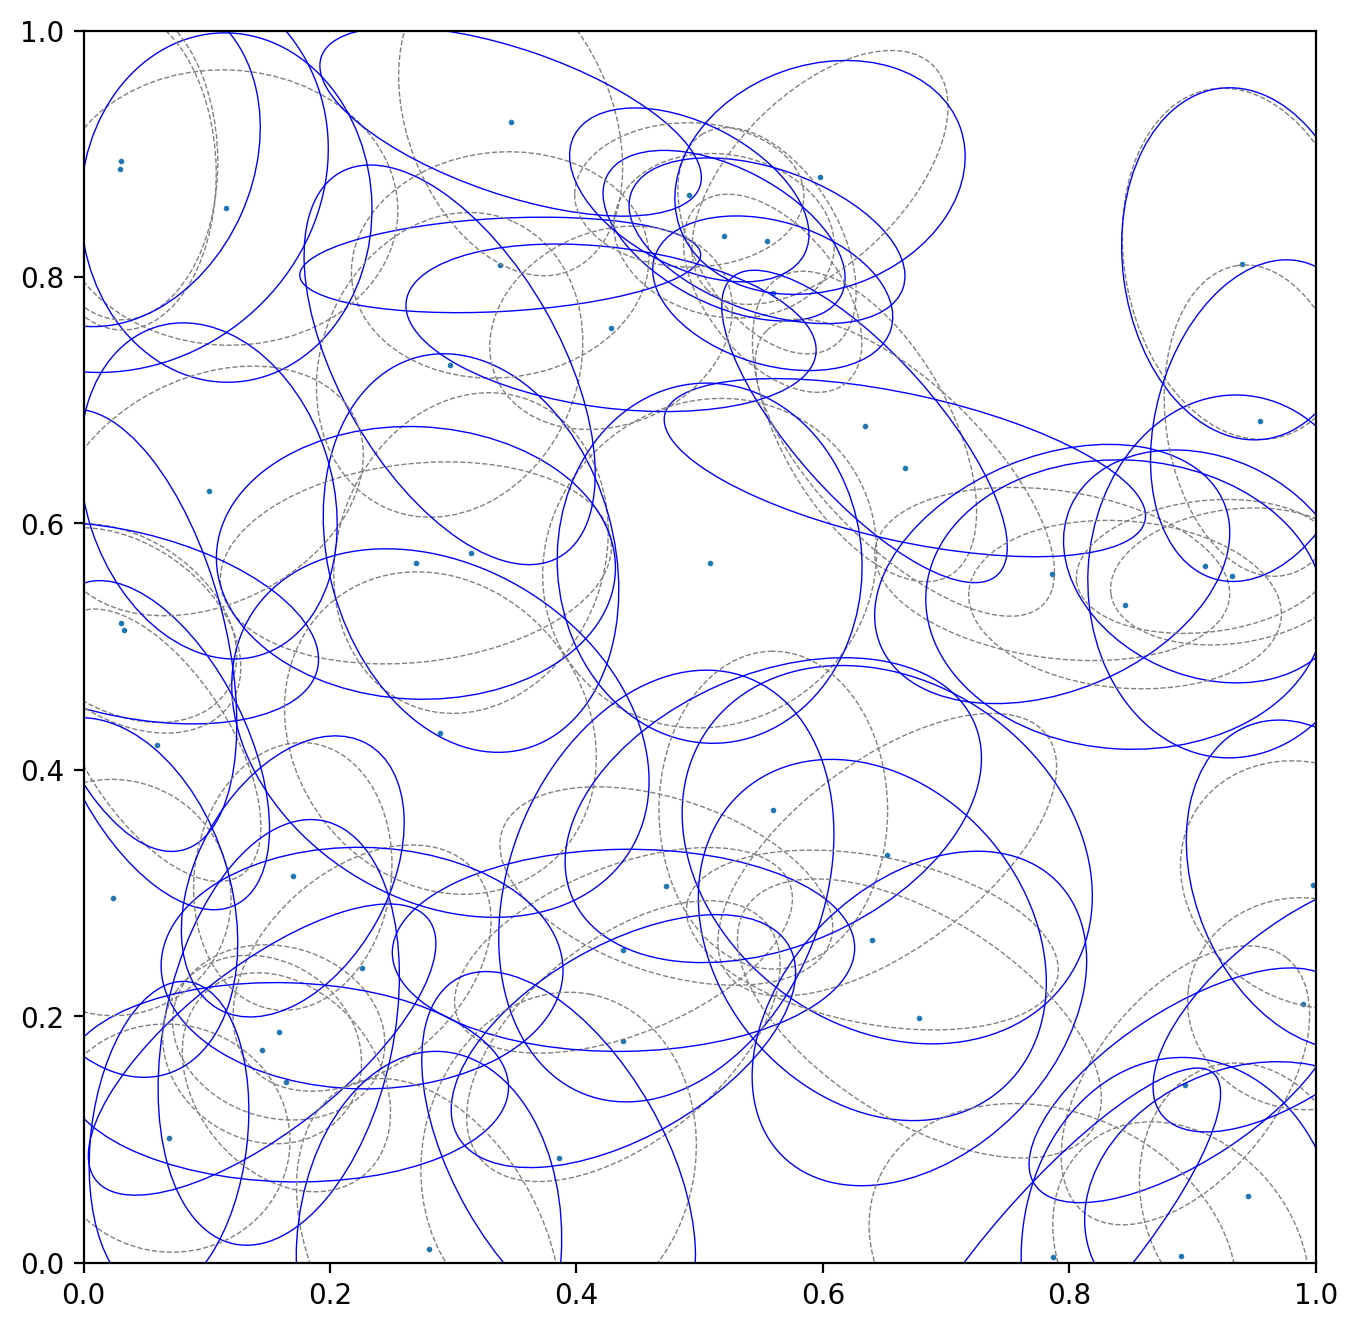

In [28]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(pos[:, 0], pos[:, 1], s=1)


for i in range(pos.shape[0]):
    #draw_circle(ax, pos[i, :2], hsm_iso[i])

    # Calculate width, height, and angle of the ellipse
    # hsm_ani_values[i] contains [eigenvalue1, eigenvalue2]
    # hsm_ani_vecs[i] contains eigenvectors as columns
    width, height = hsm_ani_values[i]
    
    # The first eigenvector corresponds to the first eigenvalue
    v = hsm_ani_vecs[i][:, 0]  # First eigenvector [vx, vy]
    angle = np.degrees(np.arctan2(v[1], v[0]))  # arctan2(vy, vx)
    
    draw_ellipse(ax, pos[i, :2], width, height, angle)

    # now the one from the 3d projected tensor
    width, height = hsm_ani_values_from_3d[i]
    
    # The first eigenvector corresponds to the first eigenvalue
    v = hsm_ani_vecs_from_3d[i][:, 0]  # First eigenvector [vx, vy]
    angle = np.degrees(np.arctan2(v[1], v[0]))  # arctan2(vy, vx)
    
    draw_ellipse(ax, pos[i, :2], width, height, angle, color='blue', ls='-')

ax.set_xlim(0, boxsize)
ax.set_ylim(0, boxsize)
ax.set_aspect('equal')
plt.show() 

In [24]:
method       = 'isotropic'
for dim in dims:
    print("-" * 50)
    print(f"Method: {method} {dim}D")

    for dataset in datasets:
        with open(f'../../../data/dataset_{dataset}_{dim}d.pkl', 'rb') as f:
            data = pickle.load(f)
        pos = data['pos'][:]
        mass = data['mass'][:, np.newaxis]
        total_mass_true = mass.sum()
        boxsize = data['boxsize']
        extent=[0, boxsize]

        hsm = compute_hsm(
            pos,
            nn=num_neigh,
            boxsize=boxsize
            #TODO: periodicity argument missing??
            )[0]
        kwargs = {'positions': pos, 
                    'quantities': mass, 
                    'hsm': hsm, 
                    'extent': extent,
                    'gridnum': gridnum,
                    'periodic': True
                    }
        
        res = p2g(
            **kwargs,
            averaged=[False] * mass.shape[1],
            method=method,
            use_python=False,
            )
        total_mass_deposited = res.sum()
            
        print(f"Total mass error on {dataset}:\t", 100 * np.round(abs(total_mass_deposited - total_mass_true) / total_mass_true, 5) if total_mass_deposited is not None else "N/A", "%")

NameError: name 'dims' is not defined